In [2]:
import pandas as pd
from datetime import datetime
import backtrader as bt
import matplotlib.pyplot as plt
%matplotlib inline
 
# #正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']


In [3]:
def get_data(code,start='2010-01-01',end='2020-3-31'):
    df = ts.get_k_data(code,autype='qfq',start=start,end=end)
    df.index = pd.to_datetime(df.date)
    df['openinterest']=0
    df=df[['open','high','low','close','volume','openinterest']]
    return df

In [4]:
import tushare as ts
dataframe=get_data('600000')

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


### 当收盘价上涨突破20日均线买入（做多），当收盘价下跌跌穿20日均线卖出（做空）

In [5]:
class Single_ma_20(bt.Strategy):
    def __init__(self):
        #指定价格序列,self.datas为datafeed进的股价数据,close为收盘价
        self.dataclose = self.datas[0].close
        #初始化交易指令、买卖价格和手续费
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        #添加移动均线指标，内置talib模块
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0],period=20)
    def next(self):
        if self.order: #检查有没有指令等待执行
            return
        # 检查是否持仓
        if not self.position: #没有持仓
            # 执行买入条件判断: 收盘价格上涨突破20日均线
            if self.dataclose[0] > self.sma[0]:
                self.order = self.buy(size = 500)
        else:
            if self.dataclose[0] <= self.sma[0]:
                self.order = self.buy(size = 500)

### backtrader 添加资金

In [6]:
start=datetime(2010, 3, 31)
end=datetime(2020, 3, 31)
data = bt.feeds.PandasData(dataname=dataframe,fromdate=start,todate=end)

In [7]:
# 初始化cerebro回测系统设置
cerebro = bt.Cerebro()
# 将数据输入回测系统
cerebro.adddata(data)
cerebro.addstrategy(Single_ma_20)

startcash = 10000
cerebro.broker.setcash(startcash) 

cerebro.broker.setcommission(commission=0.002)

In [16]:
d1=start.strftime('%Y%m%d')
d2=end.strftime('%Y%m%d')
print(f'初始资金: {startcash}\n回测期间：{d1}:{d2}')
cerebro.run()
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash
print(f'总资金: {round(portvalue,2)}')
print(f'净收益: {round(pnl,2)}')
print('收益率:{}'.format(pnl / startcash))


初始资金: 10000
回测期间：20100331:20200331
总资金: 12000.36
净收益: 2000.36
收益率:0.2000363000000001


<IPython.core.display.Javascript object>


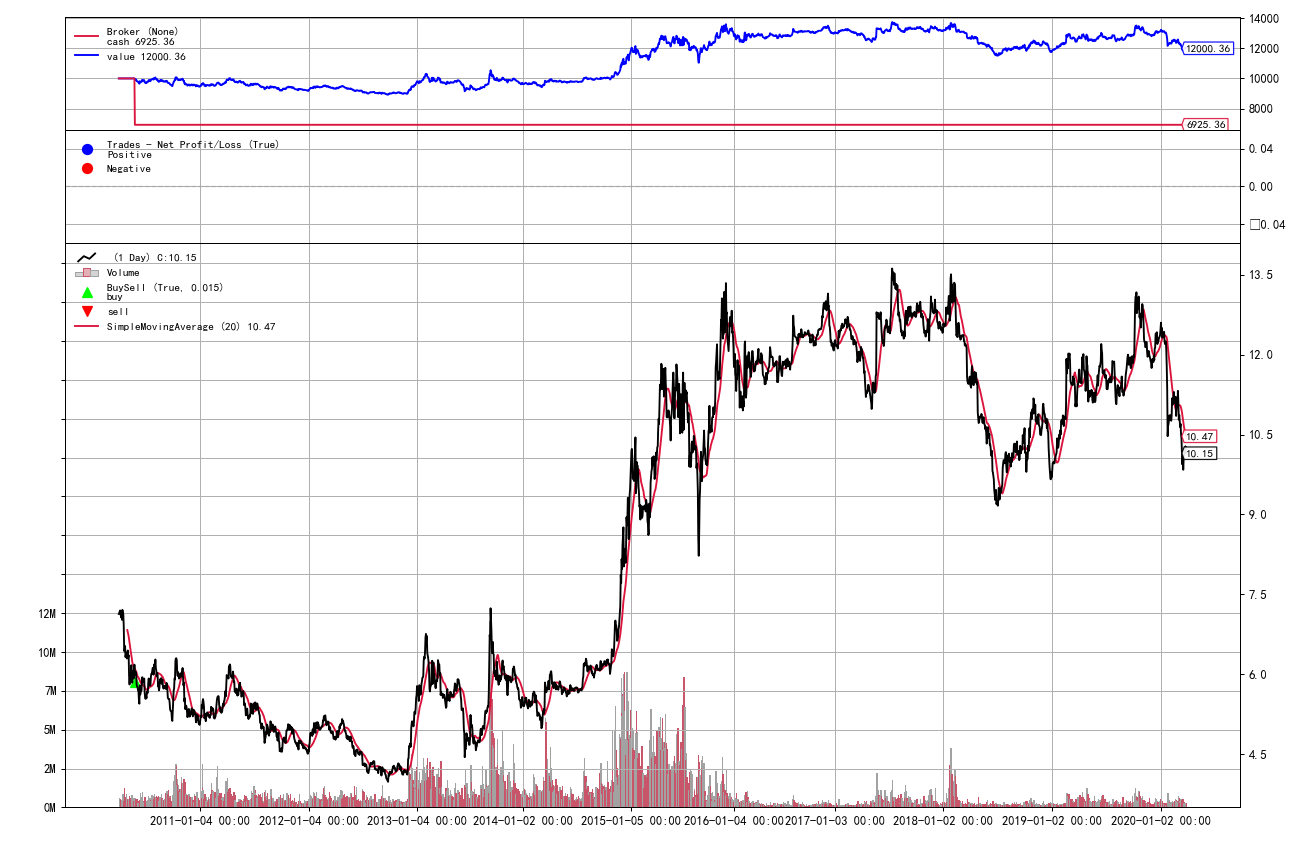

[[<Figure size 432x288 with 4 Axes>]]

In [9]:
from matplotlib import warnings
cerebro.plot()